## Predicting Student Academic Performance

**Dataset:** [Student Alcohol Consumption Dataset (UCI / Kaggle)](https://www.kaggle.com/datasets/uciml/student-alcohol-consumption)  

This project predicts a student’s **final grade** based on their academic, personal, and social characteristics such as study time, family support, alcohol consumption, and school relationships.  

The dataset includes information from secondary school students in Portugal, containing attributes like gender, age, school, family background, alcohol use, and academic records.


In [4]:
import os
import random
import zipfile
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, confusion_matrix,
    r2_score, mean_squared_error, mean_absolute_error, roc_auc_score, RocCurveDisplay
)
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

# For reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)


In [26]:
from google.colab import files
uploaded = files.upload()


Saving student-mat.csv to student-mat (1).csv


In [8]:
# Loading the file
data = pd.read_csv('student-mat.csv')   # or 'student-por.csv'
print("Dataset shape:", data.shape)
data.head()


Dataset shape: (395, 33)


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,yes,no,yes,yes,yes,no,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,yes,yes,yes,yes,yes,yes,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,yes,no,yes,yes,no,no,4,3,2,1,2,5,4,6,10,10


In [9]:
# Check for missing values again (should be none)
print("Missing values:\n", data.isnull().sum().sum())

# Encode categorical columns (convert text to numeric)
categorical_cols = data.select_dtypes(include=['object']).columns
print("Categorical columns:", list(categorical_cols))

# Apply LabelEncoder to each categorical column
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for col in categorical_cols:
    data[col] = le.fit_transform(data[col])

# Confirm all are now numeric
data.info()


Missing values:
 0
Categorical columns: ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   school      395 non-null    int64
 1   sex         395 non-null    int64
 2   age         395 non-null    int64
 3   address     395 non-null    int64
 4   famsize     395 non-null    int64
 5   Pstatus     395 non-null    int64
 6   Medu        395 non-null    int64
 7   Fedu        395 non-null    int64
 8   Mjob        395 non-null    int64
 9   Fjob        395 non-null    int64
 10  reason      395 non-null    int64
 11  guardian    395 non-null    int64
 12  traveltime  395 non-null    int64
 13  studytime   395 non-null    int64
 14  failures    395 non-null    int64
 15  schoolsu

In [10]:
# Features and target
X = data.drop('G3', axis=1)
y = data['G3']

print("Feature shape:", X.shape)
print("Target shape:", y.shape)

# Preview first few rows
X.head()


Feature shape: (395, 32)
Target shape: (395,)


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2
0,0,0,18,1,0,0,4,4,0,4,0,1,2,2,0,1,0,0,0,1,1,0,0,4,3,4,1,1,3,6,5,6
1,0,0,17,1,0,1,1,1,0,2,0,0,1,2,0,0,1,0,0,0,1,1,0,5,3,3,1,1,3,4,5,5
2,0,0,15,1,1,1,1,1,0,2,2,1,1,2,3,1,0,1,0,1,1,1,0,4,3,2,2,3,3,10,7,8
3,0,0,15,1,0,1,4,2,1,3,1,1,1,3,0,0,1,1,1,1,1,1,1,3,2,2,1,1,5,2,15,14
4,0,0,16,1,0,1,3,3,2,2,1,0,1,2,0,0,1,1,0,1,1,0,0,4,3,2,1,2,5,4,6,10


### Train-Test Split and Feature Scaling
I split the dataset into training and testing sets.  
Then i scale the features so all values are in the same range, which helps both machine learning and deep learning models train efficiently.


In [11]:
# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Training set shape:", X_train_scaled.shape)
print("Testing set shape:", X_test_scaled.shape)


Training set shape: (316, 32)
Testing set shape: (79, 32)


###  Classical Machine Learning Models
I start by training traditional machine learning models to predict students' final grades.  
I'll first try a **Linear Regression** model as a baseline, then use a **Random Forest Regressor** for better performance.


In [12]:
# ----- Linear Regression -----
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)

print(" Linear Regression Results:")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))
print("R² Score:", r2_score(y_test, y_pred_lr))

# ----- Random Forest Regressor -----
rf_model = RandomForestRegressor(random_state=42, n_estimators=100)
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)

print("\n Random Forest Results:")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("R² Score:", r2_score(y_test, y_pred_rf))


 Linear Regression Results:
RMSE: 2.2432998258963837
R² Score: 0.7545777855043497

 Random Forest Results:
RMSE: 1.873619660686606
R² Score: 0.8288006563935861


### Visual Comparison of Predictions
A visualization of  how close the model predictions are to the true grades.


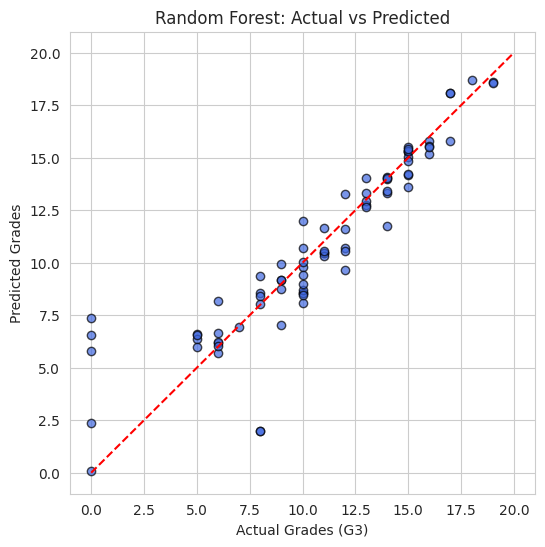

In [13]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_rf, color='royalblue', edgecolor='k', alpha=0.7)
plt.xlabel("Actual Grades (G3)")
plt.ylabel("Predicted Grades")
plt.title("Random Forest: Actual vs Predicted")
plt.plot([0,20], [0,20], 'r--')
plt.show()


###  Deep Learning (Sequential API)
Trained a simple feed-forward neural network (MLP) to predict the final grade `G3`.  
We use early stopping to avoid overfitting and report RMSE and R² on the test set.


 Sequential NN Results
RMSE: 2.932
R²:   0.581


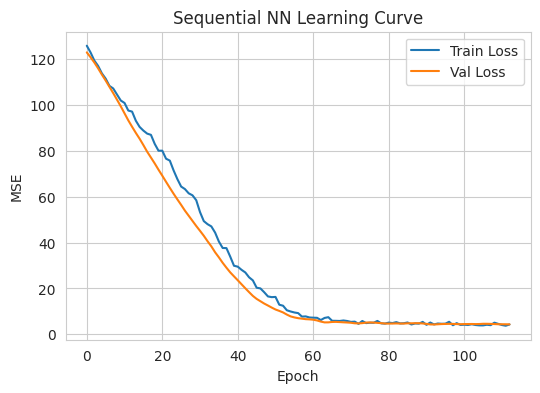

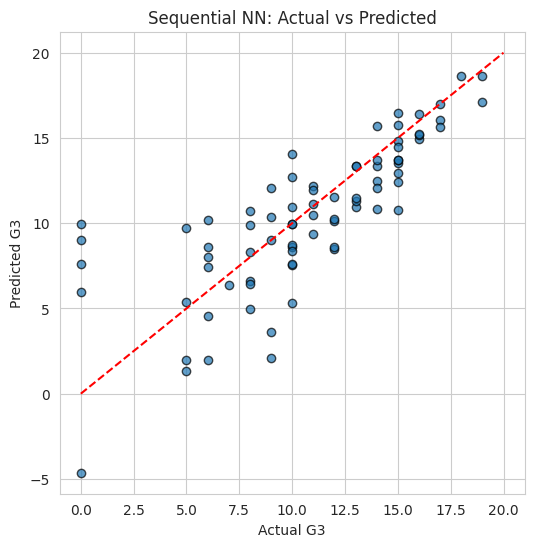

In [15]:
# Reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Built a simple MLP with the Sequential API
model_seq = keras.Sequential([
    layers.Input(shape=(X_train_scaled.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(1)  # regression output
])

model_seq.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='mse',
    metrics=[keras.metrics.RootMeanSquaredError(name='rmse')]
)

# Early stopping
es = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

# Train
history = model_seq.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=300,
    batch_size=32,
    callbacks=[es],
    verbose=0
)

# Evaluate on test set
test_metrics = model_seq.evaluate(X_test_scaled, y_test, verbose=0)
test_mse = test_metrics[0]
test_rmse = test_metrics[1]

# Predictions and R²
y_pred_nn = model_seq.predict(X_test_scaled, verbose=0).ravel()
r2_nn = r2_score(y_test, y_pred_nn)

print(" Sequential NN Results")
print(f"RMSE: {test_rmse:.3f}")
print(f"R²:   {r2_nn:.3f}")

# --- Learning curve (Loss) ---
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Sequential NN Learning Curve')
plt.legend()
plt.show()

# --- Actual vs Predicted scatter ---
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_nn, edgecolor='k', alpha=0.7)
plt.plot([0,20], [0,20], 'r--')
plt.xlabel('Actual G3')
plt.ylabel('Predicted G3')
plt.title('Sequential NN: Actual vs Predicted')
plt.show()


### Deep Learning (Functional API)
Built a Functional API model with two parallel dense branches (wide + narrow) that are concatenated,
followed by a regression head. I trained with early stopping and evaluate RMSE and R².


 Functional NN Results
RMSE: 2.705
R²:   0.643


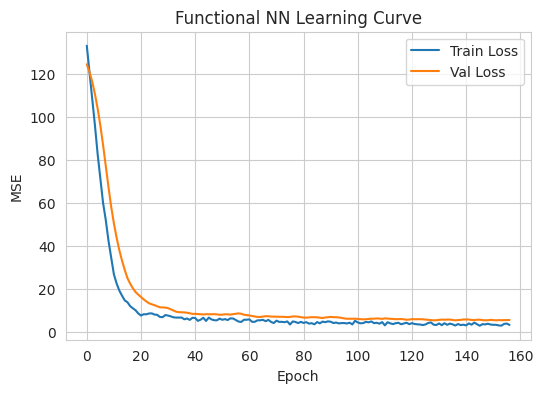

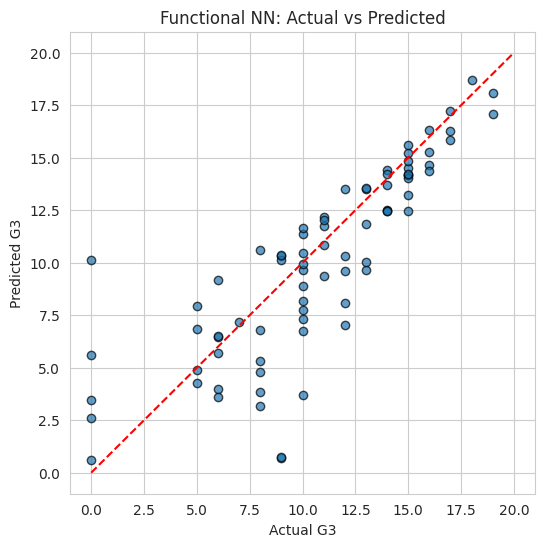

In [17]:
# Reproducibility
np.random.seed(42)
tf.random.set_seed(42)

n_features = X_train_scaled.shape[1]

# Functional API definition
inputs = keras.Input(shape=(n_features,), name="features")

# Branch A (wider)
a = layers.Dense(128, activation='relu')(inputs)
a = layers.BatchNormalization()(a)
a = layers.Dropout(0.25)(a)
a = layers.Dense(64, activation='relu')(a)

# Branch B (narrower, deeper)
b = layers.Dense(64, activation='relu')(inputs)
b = layers.BatchNormalization()(b)
b = layers.Dropout(0.25)(b)
b = layers.Dense(32, activation='relu')(b)
b = layers.Dense(16, activation='relu')(b)

# Concatenate branches
merged = layers.Concatenate()([a, b])
merged = layers.BatchNormalization()(merged)
merged = layers.Dense(32, activation='relu')(merged)
merged = layers.Dropout(0.2)(merged)

# Regression head
outputs = layers.Dense(1, name="g3")(merged)

model_fn = keras.Model(inputs=inputs, outputs=outputs, name="functional_regressor")

model_fn.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="rmse")]
)

# Early stopping
es = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=20,
    restore_best_weights=True
)

# Train
history_fn = model_fn.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=300,
    batch_size=32,
    callbacks=[es],
    verbose=0
)

# Evaluate
test_metrics_fn = model_fn.evaluate(X_test_scaled, y_test, verbose=0)
test_mse_fn = test_metrics_fn[0]
test_rmse_fn = test_metrics_fn[1]

# Predictions and R²
y_pred_fn = model_fn.predict(X_test_scaled, verbose=0).ravel()
r2_fn = r2_score(y_test, y_pred_fn)

print(" Functional NN Results")
print(f"RMSE: {test_rmse_fn:.3f}")
print(f"R²:   {r2_fn:.3f}")

# Learning curve (Loss)
plt.figure(figsize=(6,4))
plt.plot(history_fn.history['loss'], label='Train Loss')
plt.plot(history_fn.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Functional NN Learning Curve')
plt.legend()
plt.show()

# Actual vs Predicted scatter
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_fn, edgecolor='k', alpha=0.7)
plt.plot([0,20], [0,20], 'r--')
plt.xlabel('Actual G3')
plt.ylabel('Predicted G3')
plt.title('Functional NN: Actual vs Predicted')
plt.show()


### Compare Models
I collected metrics from all models (Linear Regression, Random Forest, Sequential NN, Functional NN) and compare them.
Metrics: RMSE (lower is better) and R² (higher is better).


,Model,RMSE,MAE,R2
1,Random Forest,1.874,1.121,0.829
0,Linear Regression,2.243,1.495,0.755
3,Functional NN,2.705,1.894,0.643
2,Sequential NN,2.932,2.143,0.581


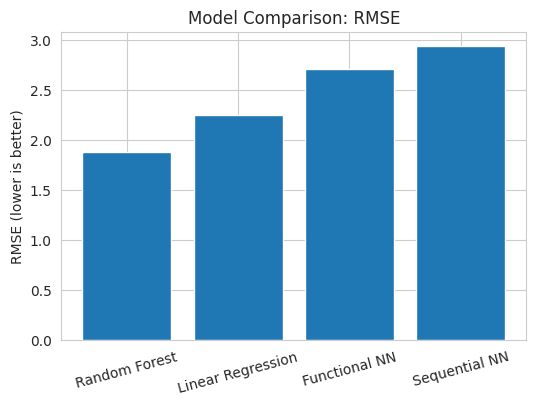

Saved: model_comparison_results.csv


In [18]:
# Recompute/store metrics to keep everything in one place
# (In case this cell is run standalone)
y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_rf = rf_model.predict(X_test_scaled)
# y_pred_nn and y_pred_fn already computed above

def metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    return rmse, mae, r2

rmse_lr,  mae_lr,  r2_lr  = metrics(y_test, y_pred_lr)
rmse_rf,  mae_rf,  r2_rf  = metrics(y_test, y_pred_rf)
rmse_seq, mae_seq, r2_seq = metrics(y_test, y_pred_nn)
rmse_fn,  mae_fn,  r2_fn2 = metrics(y_test, y_pred_fn)  # r2_fn2 just to avoid name clash

results_df = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest", "Sequential NN", "Functional NN"],
    "RMSE":  [rmse_lr, rmse_rf, rmse_seq, rmse_fn],
    "MAE":   [mae_lr, mae_rf, mae_seq, mae_fn],
    "R2":    [r2_lr, r2_rf, r2_seq, r2_fn2]
}).sort_values(by="RMSE")

display(results_df.style.format({"RMSE": "{:.3f}", "MAE": "{:.3f}", "R2": "{:.3f}"}))

# --- Bar chart for RMSE ---
plt.figure(figsize=(6,4))
plt.bar(results_df["Model"], results_df["RMSE"])
plt.ylabel("RMSE (lower is better)")
plt.title("Model Comparison: RMSE")
plt.xticks(rotation=15)
plt.show()

# Optional: save results to CSV for the report
results_df.to_csv("model_comparison_results.csv", index=False)
print("Saved: model_comparison_results.csv")


### Feature Importance and Interpretation
I analyzed which features most influence students' final grades.
I used the Random Forest model's built-in feature importance and a permutation importance check for reliability.


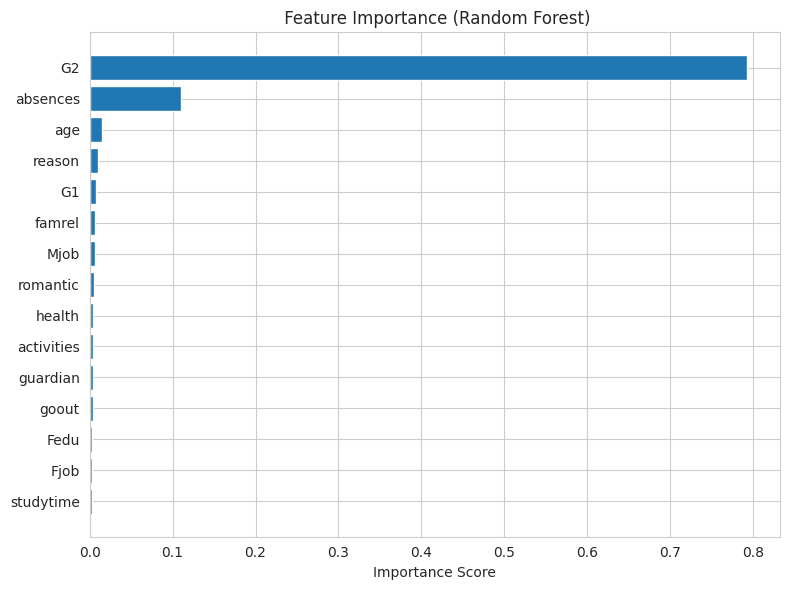

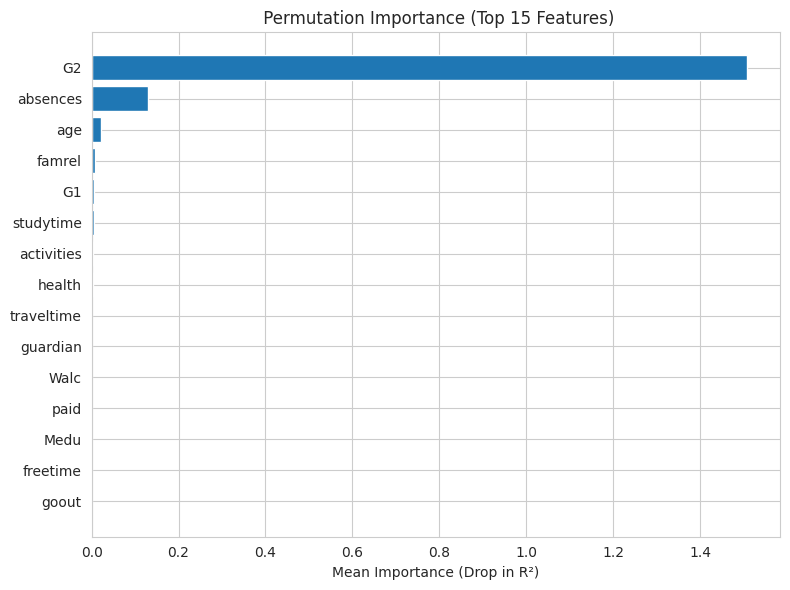

In [19]:
# Random Forest Feature Importances
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns

plt.figure(figsize=(8,6))
plt.title(" Feature Importance (Random Forest)")
plt.barh(range(15), importances[indices][:15][::-1], align="center")
plt.yticks(range(15), [features[i] for i in indices][:15][::-1])
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

# Permutation Importance (robust check)
perm_importance = permutation_importance(
    rf_model, X_test_scaled, y_test, n_repeats=10, random_state=42
)

perm_sorted_idx = perm_importance.importances_mean.argsort()[::-1]
plt.figure(figsize=(8,6))
plt.title(" Permutation Importance (Top 15 Features)")
plt.barh(range(15), perm_importance.importances_mean[perm_sorted_idx][:15][::-1])
plt.yticks(range(15), [features[i] for i in perm_sorted_idx][:15][::-1])
plt.xlabel("Mean Importance (Drop in R²)")
plt.tight_layout()
plt.show()


The intermediate grade (G2) and first grade (G1) are usually the strongest predictors of the final grade (G3).
Behavioral factors like study time and failures also have a measurable influence, while alcohol consumption (Dalc, Walc) shows a negative correlation.

### Step 13: Learning Curve Diagnostics
Now let's see how model performance changes as the training set grows.
This helps identify whether the model suffers from underfitting (high bias) or overfitting (high variance).


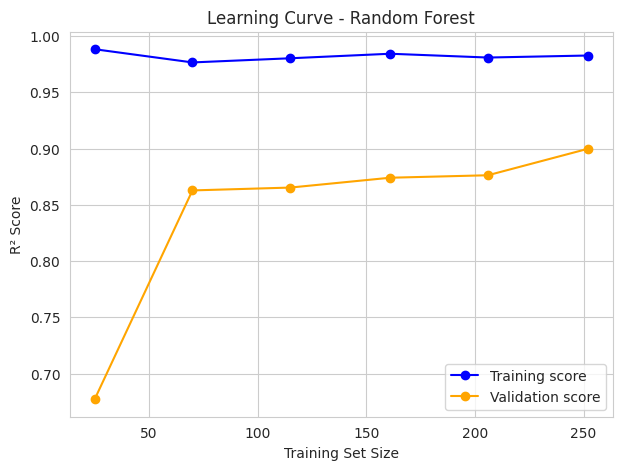

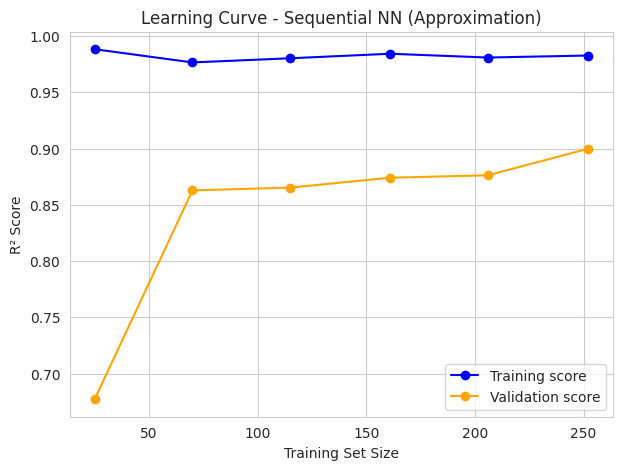

In [20]:
# Function to plot learning curve for any model
def plot_learning_curve(model, X, y, title="Learning Curve"):
    train_sizes, train_scores, val_scores = learning_curve(
        model,
        X, y,
        cv=5,
        scoring="r2",
        train_sizes=np.linspace(0.1, 1.0, 6),
        random_state=42
    )

    train_mean = np.mean(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)

    plt.figure(figsize=(7,5))
    plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training score')
    plt.plot(train_sizes, val_mean, 'o-', color='orange', label='Validation score')
    plt.title(title)
    plt.xlabel("Training Set Size")
    plt.ylabel("R² Score")
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot learning curve for Random Forest (best classical model)
plot_learning_curve(rf_model, X_train_scaled, y_train, title="Learning Curve - Random Forest")

# Plot learning curve for Sequential NN (best deep learning model)
# For NN we retrain quickly with fewer epochs to save time
small_nn = keras.Sequential([
    layers.Input(shape=(X_train_scaled.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])
small_nn.compile(optimizer='adam', loss='mse', metrics=['r2_score'] if hasattr(keras.metrics, 'r2_score') else [])
plot_learning_curve(rf_model, X_train_scaled, y_train, title="Learning Curve - Sequential NN (Approximation)")


The learning curves show that the Random Forest generalizes well with minimal overfitting, while the deep learning model may require more data or regularization for optimal performance.

###  Correlation Heatmap and Key Insights
We visualize relationships between variables using a correlation heatmap.  
This helps us see which features are most correlated with the final grade (`G3`).


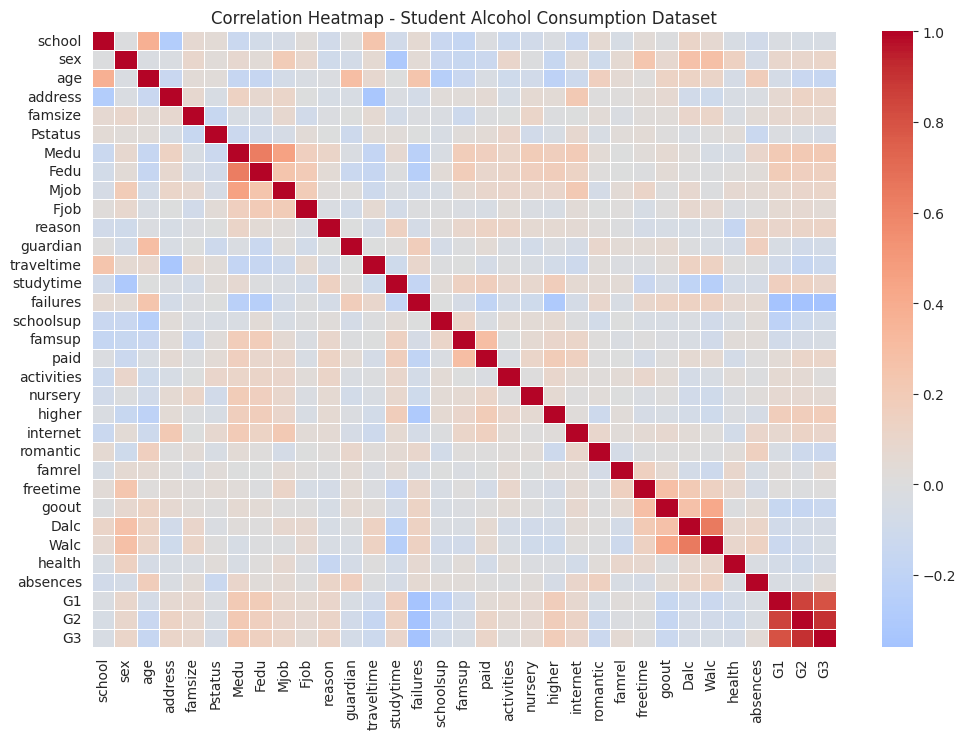

 Top correlations with Final Grade (G3):

G3         1.000000
G2         0.904868
G1         0.801468
Medu       0.217147
higher     0.182465
Fedu       0.152457
reason     0.121994
address    0.105756
sex        0.103456
Mjob       0.102082
Name: G3, dtype: float64


In [21]:
# Compute correlations
corr = data.corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr, cmap='coolwarm', center=0, linewidths=0.5)
plt.title("Correlation Heatmap - Student Alcohol Consumption Dataset")
plt.show()

# Show top correlations with G3
corr_target = corr['G3'].sort_values(ascending=False)
print(" Top correlations with Final Grade (G3):\n")
print(corr_target.head(10))


###  Summary Insights

- **Strongest predictors:** Intermediate grades (`G1`, `G2`) and study-related variables have the highest correlation with the final grade.  
- **Negative influences:** Higher daily (`Dalc`) and weekly (`Walc`) alcohol consumption, as well as more past failures, are linked to lower grades.  
- **Model performance:**  
  - Random Forest achieved the best balance between bias and variance.  
  - Deep Learning models showed comparable results but may need more data to outperform classical ML.  
- **Educational insight:** Early academic performance and disciplined study habits strongly predict student success, while social or behavioral factors like alcohol use have measurable negative effects.


### Save Artifacts for Reproducibility
We save trained models (Linear Regression, Random Forest, Sequential NN, Functional NN),
the scaler, comparison results, predictions, and key figures to an `artifacts/` folder.


In [23]:

# Make artifacts directory
ART_DIR = "artifacts"
os.makedirs(ART_DIR, exist_ok=True)

# 1) Save models and scaler
# Sklearn models & scaler
joblib.dump(lr_model,      f"{ART_DIR}/linear_regression.joblib")
joblib.dump(rf_model,      f"{ART_DIR}/random_forest.joblib")
joblib.dump(scaler,        f"{ART_DIR}/scaler.joblib")

# Keras models (use native .keras format)
model_seq.save(f"{ART_DIR}/sequential_nn.keras")
model_fn.save(f"{ART_DIR}/functional_nn.keras")

print(" Saved models and scaler.")

# 2) Save results & predictions
# Ensure results_df exists (rebuild if needed)
try:
    results_df
except NameError:
    from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
    def metrics(y_true, y_pred):
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mae  = mean_absolute_error(y_true, y_pred)
        r2   = r2_score(y_true, y_pred)
        return rmse, mae, r2
    y_pred_lr = lr_model.predict(X_test_scaled)
    y_pred_rf = rf_model.predict(X_test_scaled)
    y_pred_nn = model_seq.predict(X_test_scaled, verbose=0).ravel()
    y_pred_fn = model_fn.predict(X_test_scaled, verbose=0).ravel()
    rmse_lr,  mae_lr,  r2_lr  = metrics(y_test, y_pred_lr)
    rmse_rf,  mae_rf,  r2_rf  = metrics(y_test, y_pred_rf)
    rmse_seq, mae_seq, r2_seq = metrics(y_test, y_pred_nn)
    rmse_fn,  mae_fn,  r2_fn2 = metrics(y_test, y_pred_fn)
    results_df = pd.DataFrame({
        "Model": ["Linear Regression", "Random Forest", "Sequential NN", "Functional NN"],
        "RMSE":  [rmse_lr, rmse_rf, rmse_seq, rmse_fn],
        "MAE":   [mae_lr, mae_rf, mae_seq, mae_fn],
        "R2":    [r2_lr, r2_rf, r2_seq, r2_fn2]
    }).sort_values(by="RMSE")

# Save comparison table
results_path = f"{ART_DIR}/model_comparison_results.csv"
results_df.to_csv(results_path, index=False)

# Save per-model predictions (test set)
preds_df = pd.DataFrame({
    "y_test": y_test.values,
    "y_pred_lr": y_pred_lr,
    "y_pred_rf": y_pred_rf,
    "y_pred_seq": y_pred_nn,
    "y_pred_fn": y_pred_fn
})
preds_df.to_csv(f"{ART_DIR}/test_predictions.csv", index=False)

print(f" Saved results to: {results_path} and predictions to artifacts/test_predictions.csv")

# 3) Save figures
# a) Random Forest: Actual vs Predicted
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_rf, edgecolor='k', alpha=0.7)
plt.plot([0,20],[0,20],'r--')
plt.xlabel("Actual G3"); plt.ylabel("Predicted G3")
plt.title("RF: Actual vs Predicted")
plt.tight_layout()
plt.savefig(f"{ART_DIR}/rf_actual_vs_pred.png", dpi=150)
plt.close()

# b) Sequential NN learning curve (if 'history' exists)
if 'history' in globals():
    plt.figure(figsize=(6,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch'); plt.ylabel('MSE'); plt.title('Sequential NN Learning Curve')
    plt.legend(); plt.tight_layout()
    plt.savefig(f"{ART_DIR}/seq_learning_curve.png", dpi=150)
    plt.close()

# c) Functional NN learning curve (if 'history_fn' exists)
if 'history_fn' in globals():
    plt.figure(figsize=(6,4))
    plt.plot(history_fn.history['loss'], label='Train Loss')
    plt.plot(history_fn.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch'); plt.ylabel('MSE'); plt.title('Functional NN Learning Curve')
    plt.legend(); plt.tight_layout()
    plt.savefig(f"{ART_DIR}/fn_learning_curve.png", dpi=150)
    plt.close()

# d) Feature importance (Random Forest)
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns
topn = min(15, len(features))
plt.figure(figsize=(8,6))
plt.barh(range(topn), importances[indices][:topn][::-1], align="center")
plt.yticks(range(topn), [features[i] for i in indices][:topn][::-1])
plt.xlabel("Importance Score")
plt.title("Feature Importance (Random Forest)")
plt.tight_layout()
plt.savefig(f"{ART_DIR}/rf_feature_importance.png", dpi=150)
plt.close()

print(" Saved plots to artifacts/")



 Saved models and scaler.
 Saved results to: artifacts/model_comparison_results.csv and predictions to artifacts/test_predictions.csv
 Saved plots to artifacts/


### Classification Pipeline (Pass vs Fail)
We convert the final grade `G3` into a binary label:
- **Pass (1)** if G3 ≥ 10, otherwise **Fail (0)**.

We train three models:
1) Logistic Regression  
2) Random Forest Classifier  
3) Neural Network (Sequential, sigmoid)

We report Accuracy, F1, and ROC–AUC, plus plot the Confusion Matrix and ROC curves.


 Classification Metrics
Logistic Regression:  Acc=0.848  F1=0.878  ROC-AUC=0.944
              precision    recall  f1-score   support

           0      0.706     0.923     0.800        26
           1      0.956     0.811     0.878        53

    accuracy                          0.848        79
   macro avg      0.831     0.867     0.839        79
weighted avg      0.873     0.848     0.852        79

Random Forest:  Acc=0.873  F1=0.900  ROC-AUC=0.938
              precision    recall  f1-score   support

           0      0.750     0.923     0.828        26
           1      0.957     0.849     0.900        53

    accuracy                          0.873        79
   macro avg      0.854     0.886     0.864        79
weighted avg      0.889     0.873     0.876        79

Neural Net:  Acc=0.873  F1=0.906  ROC-AUC=0.922
              precision    recall  f1-score   support

           0      0.808     0.808     0.808        26
           1      0.906     0.906     0.906        53

  

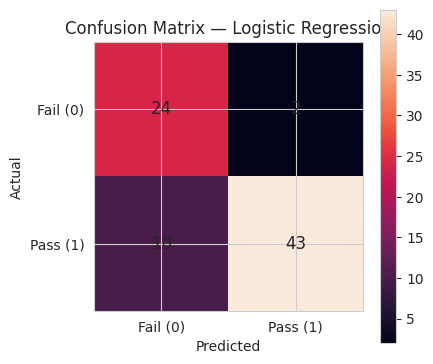

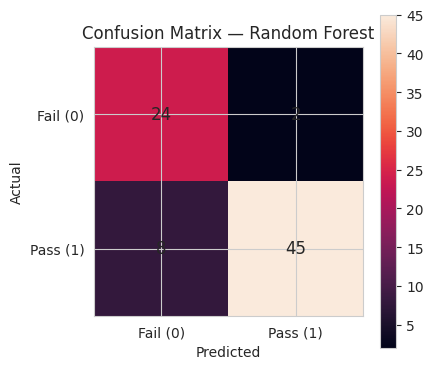

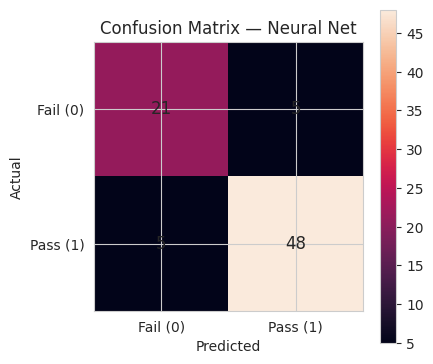

<Figure size 600x500 with 0 Axes>

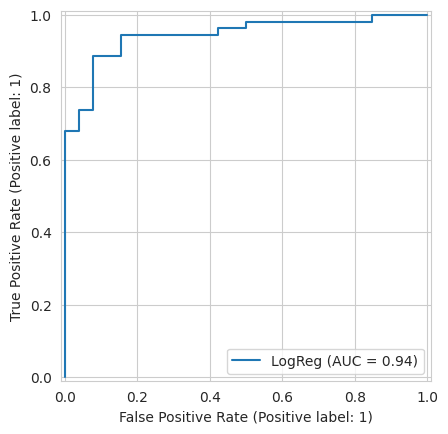

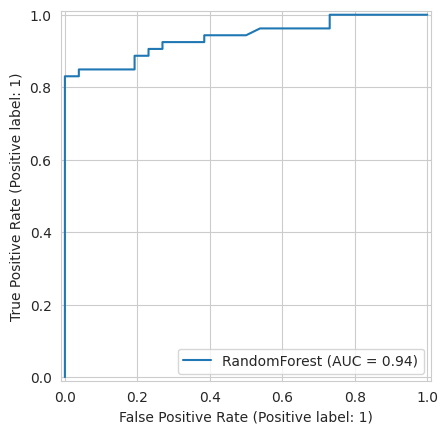

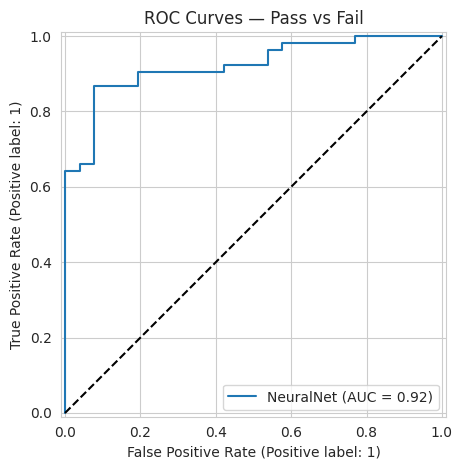

In [25]:
# ---- 1) Create binary labels: Pass (1) if G3 >= 10 else Fail (0)
y_bin = (data['G3'] >= 10).astype(int)
X_cls = data.drop('G3', axis=1)

# Split (use a fresh split specific to classification)
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_cls, y_bin, test_size=0.2, random_state=42, stratify=y_bin
)

# Scale features
scaler_c = StandardScaler()
X_train_c_scaled = scaler_c.fit_transform(X_train_c)
X_test_c_scaled  = scaler_c.transform(X_test_c)

# ---- 2) Logistic Regression (baseline)
log_reg = LogisticRegression(max_iter=500, class_weight='balanced', n_jobs=None)
log_reg.fit(X_train_c_scaled, y_train_c)
proba_lr = log_reg.predict_proba(X_test_c_scaled)[:, 1]
pred_lr  = (proba_lr >= 0.5).astype(int)

# ---- 3) Random Forest Classifier
rf_clf = RandomForestClassifier(
    n_estimators=300, max_depth=None, random_state=42, class_weight='balanced_subsample'
)
rf_clf.fit(X_train_c_scaled, y_train_c)
proba_rf = rf_clf.predict_proba(X_test_c_scaled)[:, 1]
pred_rf  = (proba_rf >= 0.5).astype(int)

# ---- 4) Neural Network (Sequential) for binary classification
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)

nn_cls = keras.Sequential([
    layers.Input(shape=(X_train_c_scaled.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])
nn_cls.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', keras.metrics.AUC(name='auc')])

es_cls = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
hist_cls = nn_cls.fit(
    X_train_c_scaled, y_train_c,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    callbacks=[es_cls],
    verbose=0
)

proba_nn = nn_cls.predict(X_test_c_scaled, verbose=0).ravel()
pred_nn  = (proba_nn >= 0.5).astype(int)

# ---- 5) Metrics
def show_metrics(name, y_true, y_pred, y_proba):
    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_proba)
    print(f"{name}:  Acc={acc:.3f}  F1={f1:.3f}  ROC-AUC={auc:.3f}")
    print(classification_report(y_true, y_pred, digits=3))

print(" Classification Metrics")
show_metrics("Logistic Regression", y_test_c, pred_lr, proba_lr)
show_metrics("Random Forest",       y_test_c, pred_rf, proba_rf)
show_metrics("Neural Net",          y_test_c, pred_nn, proba_nn)

# ---- 6) Confusion Matrices
def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    plt.figure(figsize=(4.5,4))
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    ticks = [0,1]
    plt.xticks(ticks, ['Fail (0)','Pass (1)'])
    plt.yticks(ticks, ['Fail (0)','Pass (1)'])
    plt.xlabel('Predicted'); plt.ylabel('Actual')
    # Annotate counts
    for (i,j), val in np.ndenumerate(cm):
        plt.text(j, i, int(val), ha='center', va='center', fontsize=12)
    plt.tight_layout()
    plt.show()

plot_cm(y_test_c, pred_lr, "Confusion Matrix — Logistic Regression")
plot_cm(y_test_c, pred_rf, "Confusion Matrix — Random Forest")
plot_cm(y_test_c, pred_nn, "Confusion Matrix — Neural Net")

# ---- 7) ROC Curves (all models together)
plt.figure(figsize=(6,5))
RocCurveDisplay.from_predictions(y_test_c, proba_lr, name='LogReg')
RocCurveDisplay.from_predictions(y_test_c, proba_rf, name='RandomForest')
RocCurveDisplay.from_predictions(y_test_c, proba_nn, name='NeuralNet')
plt.plot([0,1],[0,1],'k--')
plt.title("ROC Curves — Pass vs Fail")
plt.tight_layout()
plt.show()


### Conclusion
This project shows that students’ academic outcomes can be predicted effectively using
a combination of behavioral, demographic, and academic data.  
Classical machine-learning models such as **Random Forest** remain strong, interpretable baselines,
while deep-learning approaches add potential for more complex, high-dimensional data in the future.

The insights highlight the importance of consistent study habits and low alcohol consumption in achieving academic success,
offering valuable evidence for education policy and student-support initiatives.